# Machine Learning Model Experiments

## Experiment Setup

In [1]:
# Setting up execution path
import os

print(f"Current working directory: {os.path.basename(os.getcwd())}")

# Change to root directory
os.chdir("../")
print(f"Current working directory (Changed): {os.path.basename(os.getcwd())}")

Current working directory: notebooks
Current working directory (Changed): Lending-Approval-Predictor


In [2]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# module setup
%matplotlib inline
pd.options.display.precision = 3
warnings.filterwarnings("ignore")

In [3]:
from os.path import dirname, normpath

In [4]:
from src.constants import CONFIGS, PARAMS
from src.exception import CustomException
from src.logger import logger
from src.utils.basic_utils import create_directories, read_yaml

In [5]:
# Read the configuration files
configs = read_yaml(CONFIGS).model_evaluation

# Train and test array paths
train_array_path = normpath(configs.train_array_path)
test_array_path = normpath(configs.test_array_path)

[2024-02-14 06:41:39 PM]:ProjectLogger INFO:basic_utils 43 - yaml file: conf\configs.yaml loaded successfully


In [6]:
# Load the training and test set array
train_array = np.load(train_array_path)
test_array = np.load(test_array_path)

# Split train_array into features and target
x_train, y_train = train_array[:, :-1], train_array[:, -1]
x_test, y_test = test_array[:, :-1], test_array[:, -1]

# Log the shapes
print(f"The shape of x_train: {x_train.shape}")
print(f"The shape of y_train: {y_train.shape}")

print(f"The shape of x_test: {x_test.shape}")
print(f"The shape of y_test: {y_test.shape}")

The shape of x_train: (7662, 19)
The shape of y_train: (7662,)
The shape of x_test: (1916, 19)
The shape of y_test: (1916,)


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [8]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
}

In [9]:
# Read the params files
params = read_yaml(PARAMS)

[2024-02-14 06:41:44 PM]:ProjectLogger INFO:basic_utils 43 - yaml file: conf\params.yaml loaded successfully


In [10]:
# Params content
print(params.random_forest.to_dict())
print(params.decision_tree.to_dict())

{'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2'], 'n_estimators': [8, 16, 32, 64, 128, 256]}
{'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_features': ['sqrt', 'log2']}


In [11]:
hyper_params = {
    "Decision Tree": params.decision_tree.to_dict(),
    "Random Forest": params.random_forest.to_dict(),
}

In [12]:
# hyper_params = {
#     "Decision Tree": {
#         "criterion": ["gini", "entropy", "log_loss"],
#         "splitter": ["best", "random"],
#         "max_features": ["sqrt", "log2"],
#     },
#     "Random Forest": {
#         "criterion": ["gini", "entropy", "log_loss"],
#         "max_features": ["sqrt", "log2"],
#         "n_estimators": [8, 16, 32, 64, 128, 256],
#     },
# }

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [14]:
from src.utils.model_utils import evaluate_classification_models, get_best_model

In [15]:
model_scores = evaluate_classification_models(
    x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, 
    models=models, params=hyper_params, binary_classification=True)

In [16]:
model_scores

[{'model_name': 'Decision Tree',
  'model': DecisionTreeClassifier(criterion='log_loss', max_features='log2'),
  'hyperparameters': {'criterion': 'log_loss',
   'max_features': 'log2',
   'splitter': 'best'},
  'accuracy_score_train': 1.0,
  'precision_score_train': 1.0,
  'recall_score_train': 1.0,
  'f1_score_train': 1.0,
  'accuracy_score_test': 0.9775574112734864,
  'precision_score_test': 0.9845061329890252,
  'recall_score_test': 0.9876943005181347,
  'f1_score_test': 0.9860976398318785},
 {'model_name': 'Random Forest',
  'model': RandomForestClassifier(criterion='log_loss', n_estimators=16),
  'hyperparameters': {'criterion': 'log_loss',
   'max_features': 'sqrt',
   'n_estimators': 16},
  'accuracy_score_train': 0.9997389715478987,
  'precision_score_train': 0.9996757457846952,
  'recall_score_train': 1.0,
  'f1_score_train': 0.9998378466028863,
  'accuracy_score_test': 0.9859081419624217,
  'precision_score_test': 0.986529826812059,
  'recall_score_test': 0.9961139896373057,


In [17]:
scores_df = pd.DataFrame(model_scores)
scores_df

,model_name,model,hyperparameters,accuracy_score_train,precision_score_train,recall_score_train,f1_score_train,accuracy_score_test,precision_score_test,recall_score_test,f1_score_test
0,Decision Tree,"DecisionTreeClassifier(criterion='log_loss', m...","{'criterion': 'log_loss', 'max_features': 'log...",1.0,1.0,1.0,1.0,0.978,0.985,0.988,0.986
1,Random Forest,"(DecisionTreeClassifier(criterion='log_loss', ...","{'criterion': 'log_loss', 'max_features': 'sqr...",1.0,1.0,1.0,1.0,0.986,0.987,0.996,0.991


In [22]:
best_model = get_best_model(scores_df, evaluation_metric="f1_score_test")
best_model

{'model_name': 'Random Forest',
 'model': RandomForestClassifier(criterion='log_loss', n_estimators=16),
 'hyperparameters': {'criterion': 'log_loss',
  'max_features': 'sqrt',
  'n_estimators': 16}}

In [24]:
rf_model = best_model["model"]
rf_model

RandomForestClassifier(criterion='log_loss', n_estimators=16)

In [61]:
y_train_pred = rf_model.predict(x_train)
y_test_pred = rf_model.predict(x_test)

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def classification_metrics(y_true, y_pred) -> dict:
    """
    Calculates the classification metrics accuracy, precision, recall, and F1 score.
    """
    accuracy =  accuracy_score(y_true, y_pred)
    precision =  precision_score(y_true, y_pred)    
    recall =  recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    classification_dict = {
        "Accuracy": round(accuracy, 2),
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1 Score": round(f1, 2)
    }
    return classification_dict

In [63]:
test_eval_metrics = classification_metrics(y_test, y_test_pred)
test_eval_metrics

{'Accuracy': 0.99, 'Precision': 0.99, 'Recall': 1.0, 'F1 Score': 0.99}

In [64]:
train_eval_metrics = classification_metrics(y_train, y_train_pred)
train_eval_metrics

{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names: list):
  """
  Plots the confusion matrix for evaluating classification model
  """

  # calculate confusion matrix values
  cm = confusion_matrix(y_true, y_pred)
  cm_pct = confusion_matrix(y_true, y_pred, normalize="true")

  # confusion matrix display objects
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=class_names)
  disp_pct = ConfusionMatrixDisplay(confusion_matrix=cm_pct,
                                  display_labels=class_names)

  # create the figure object and axis
  fig = plt.figure(figsize=(20, 15))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)

  # plot confusion matrix on the axis
  disp.plot(ax=ax1, cmap="Blues", xticks_rotation='vertical', colorbar=False)
  disp_pct.plot(ax=ax2, cmap="Blues", xticks_rotation="vertical", colorbar=False, values_format='.2%')

  # plot customization
  ax1.set_title("Confusion Matrix", fontdict={'weight':'bold'})
  ax2.set_title("Confusion Matrix (Percentages)", fontdict={'weight':'bold'})

  # show plot
  plt.show()

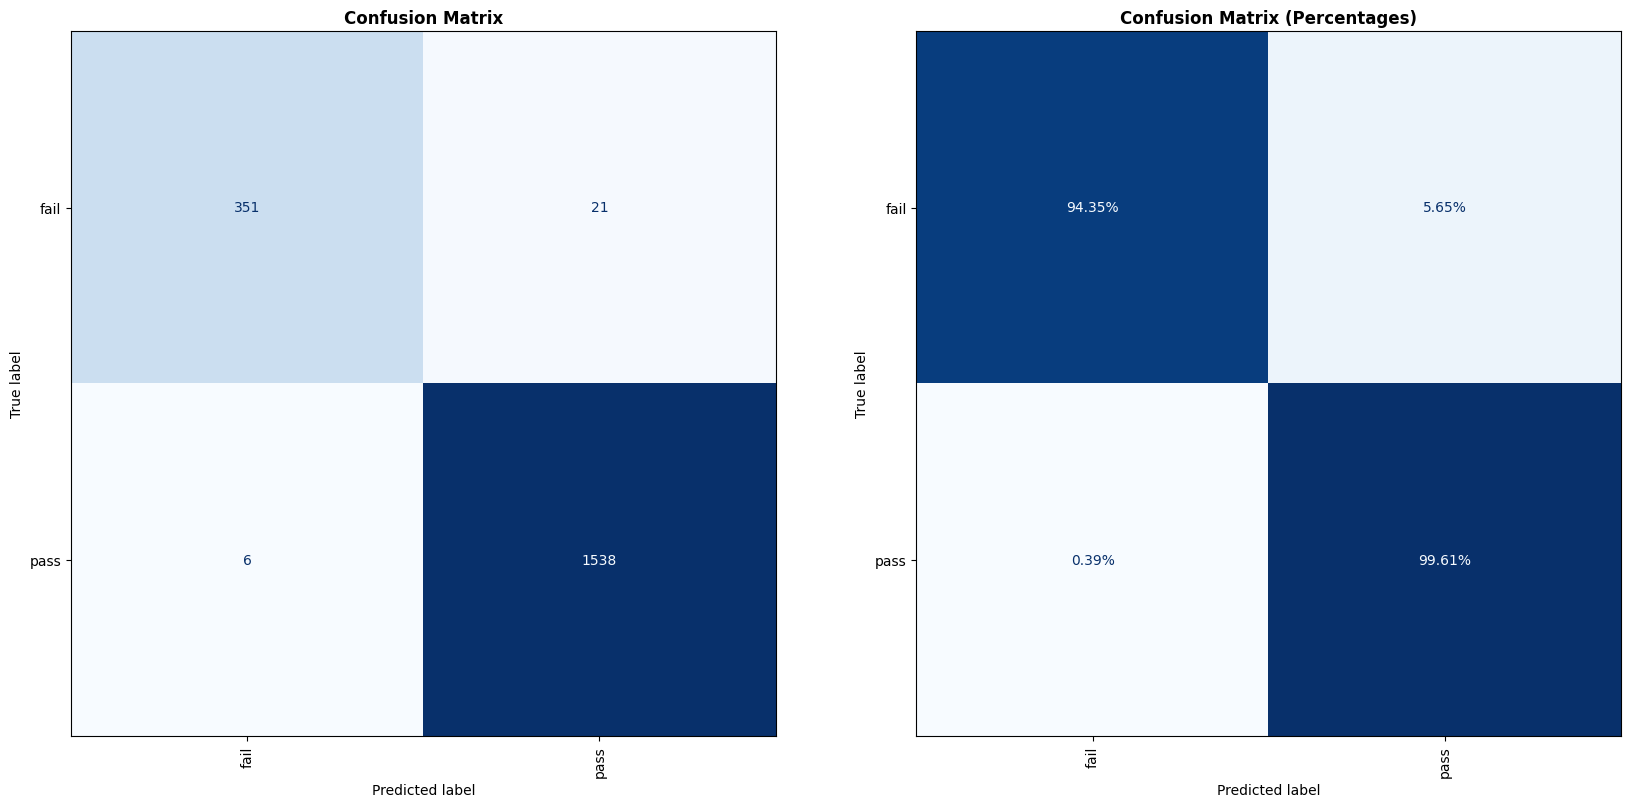

In [90]:
plot_confusion_matrix(y_test, y_test_pred, class_names=["fail", "pass"])

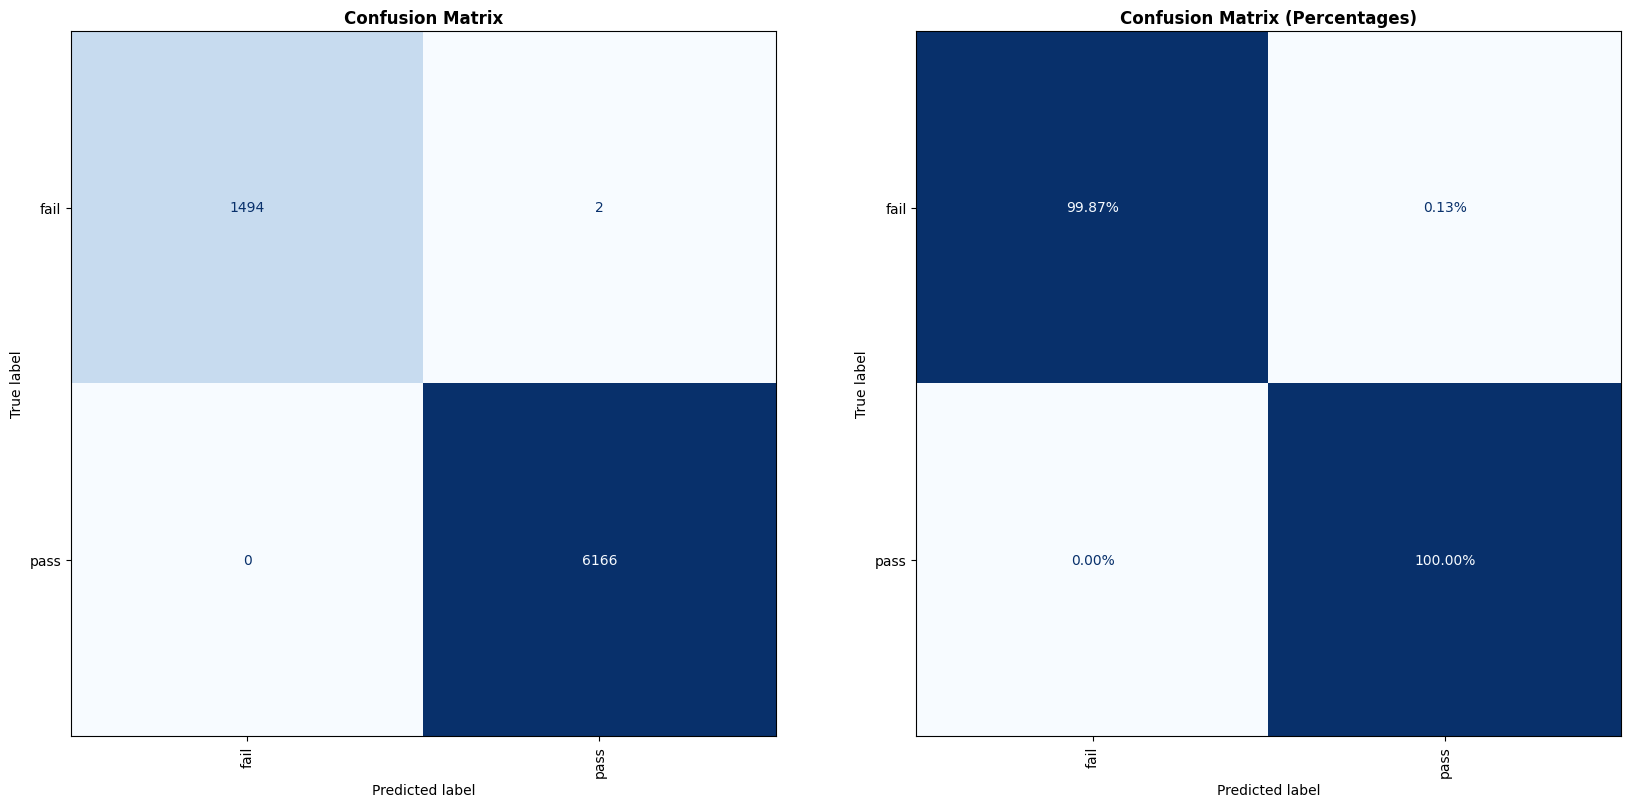

In [91]:
plot_confusion_matrix(y_train, y_train_pred, class_names=["fail", "pass"])

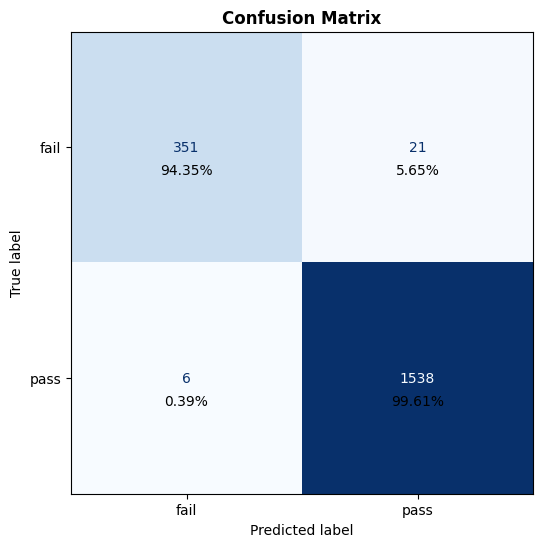

In [120]:
# Calculate confusion matrix values
cm = confusion_matrix(y_test, y_test_pred)
cm_pct = confusion_matrix(y_test, y_test_pred, normalize="true")


# Confusion matrix display objects
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=["fail","pass"])


# Create the figure object and axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

# Plot confusion matrix on the axis
disp.plot(ax=ax, cmap="Blues", colorbar=False) 

# Annotate confusion matrix with percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i+0.1, '{:.2%}'.format(cm_pct[i, j]),
                ha='center', va='center')

# Plot customization
ax.set_title("Confusion Matrix", fontdict={'weight':'bold'})

# Show plot
plt.show()

In [125]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, output_dict=False))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       372
         1.0       0.99      1.00      0.99      1544

    accuracy                           0.99      1916
   macro avg       0.98      0.97      0.98      1916
weighted avg       0.99      0.99      0.99      1916



In [133]:
cr_dict = classification_report(y_test, y_test_pred, output_dict=True)
pd.DataFrame(cr_dict).transpose()

,precision,recall,f1-score,support
0.0,0.983,0.944,0.963,372.000
1.0,0.987,0.996,0.991,1544.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.985,0.970,0.977,1916.000
weighted avg,0.986,0.986,0.986,1916.000
